In [ ]:
import io
import keras

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# **Data Preprocessing and Augmentation**

In [23]:
data = pd.read_csv('Dataset\\FETAL_PLANES_ZENODO\\merged_data.csv')

data = data.dropna(subset=['Image_path'])

# Label encoding
le = LabelEncoder()
data['Plane'] = le.fit_transform(data['Plane'])

# Split data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='Image_path',
    y_col='Plane',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col='Image_path',
    y_col='Plane',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='Image_path',
    y_col='Plane',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)


Found 7936 validated image filenames.
Found 1984 validated image filenames.
Found 2480 validated image filenames.


# **Building the VGG19 Model**

In [24]:
# VGG19 model architecture
def build_vgg19_model(input_shape=(224, 224, 3), num_classes=6):
    base_model = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    
    base_model.trainable = False  # Freezing the base model layers
    
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Hyperparameters
learning_rate = 0.0001
epochs = 30


vgg19_model = build_vgg19_model()

vgg19_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 32,873,030
Trainable params: 12,848,646
Non-trainable params: 20,024,384
_________________________________________________________________


# **Compile the Model**

In [25]:
# Compile VGG19 model
vgg19_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

# **Callbacks**

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_vgg19_model.h5", save_best_only=True)

# Train function
def train_vgg19_model(model, train_gen, val_gen, epochs=30):
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[early_stopping, model_checkpoint]
    )
    return history


# **Model Training**

In [27]:
# Train call
history_vgg19 = train_vgg19_model(vgg19_model, train_generator, val_generator, epochs=epochs)

# Save
vgg19_model.save("trained_vgg19_model.h5")

history_vgg19.history


Epoch 1/30
248/248 [==============================] - 269s 1s/step - loss: 1.0063 - accuracy: 0.6343 - val_loss: 0.5553 - val_accuracy: 0.8075
Epoch 2/30
248/248 [==============================] - 97s 389ms/step - loss: 0.7132 - accuracy: 0.7399 - val_loss: 0.4890 - val_accuracy: 0.8201
Epoch 3/30
248/248 [==============================] - 95s 384ms/step - loss: 0.6507 - accuracy: 0.7589 - val_loss: 0.4481 - val_accuracy: 0.8412
Epoch 4/30
248/248 [==============================] - 98s 393ms/step - loss: 0.5986 - accuracy: 0.7850 - val_loss: 0.4180 - val_accuracy: 0.8503
Epoch 5/30
248/248 [==============================] - 100s 404ms/step - loss: 0.5826 - accuracy: 0.7855 - val_loss: 0.4069 - val_accuracy: 0.8569
Epoch 6/30
248/248 [==============================] - 97s 392ms/step - loss: 0.5617 - accuracy: 0.7931 - val_loss: 0.4316 - val_accuracy: 0.8377
Epoch 7/30
248/248 [==============================] - 96s 387ms/step - loss: 0.5312 - accuracy: 0.8047 - val_loss: 0.3664 - val_acc

{'loss': [1.0063419342041016,
  0.7132224440574646,
  0.6506949067115784,
  0.5986483097076416,
  0.5825554728507996,
  0.5617480278015137,
  0.5311951637268066,
  0.5176635384559631,
  0.5227159857749939,
  0.5112243294715881,
  0.4949300289154053,
  0.49593356251716614,
  0.4729582369327545,
  0.4873584806919098,
  0.4630556106567383,
  0.45906639099121094,
  0.4419209659099579,
  0.4348120391368866,
  0.44606250524520874,
  0.43626970052719116],
 'accuracy': [0.6343246102333069,
  0.7399193644523621,
  0.7589465975761414,
  0.7850302457809448,
  0.7855342626571655,
  0.7930947542190552,
  0.8046875,
  0.8102318644523621,
  0.8131300210952759,
  0.8142641186714172,
  0.8193044066429138,
  0.8179183602333069,
  0.8283770084381104,
  0.8243447542190552,
  0.828881025314331,
  0.8317792415618896,
  0.8373236060142517,
  0.842993974685669,
  0.836693525314331,
  0.840599775314331],
 'val_loss': [0.555306077003479,
  0.48898544907569885,
  0.4481365978717804,
  0.41804736852645874,
  0.40

# **Accuracy Percentage**

In [28]:
train_accuracy = history_vgg19.history['accuracy'][-1]  # last epoch's accuracy
val_accuracy = history_vgg19.history['val_accuracy'][-1]  # last epoch's validation accuracy

print(f"Training accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

Training accuracy: 84.06%
Validation accuracy: 88.76%


# **Plotting Graph**

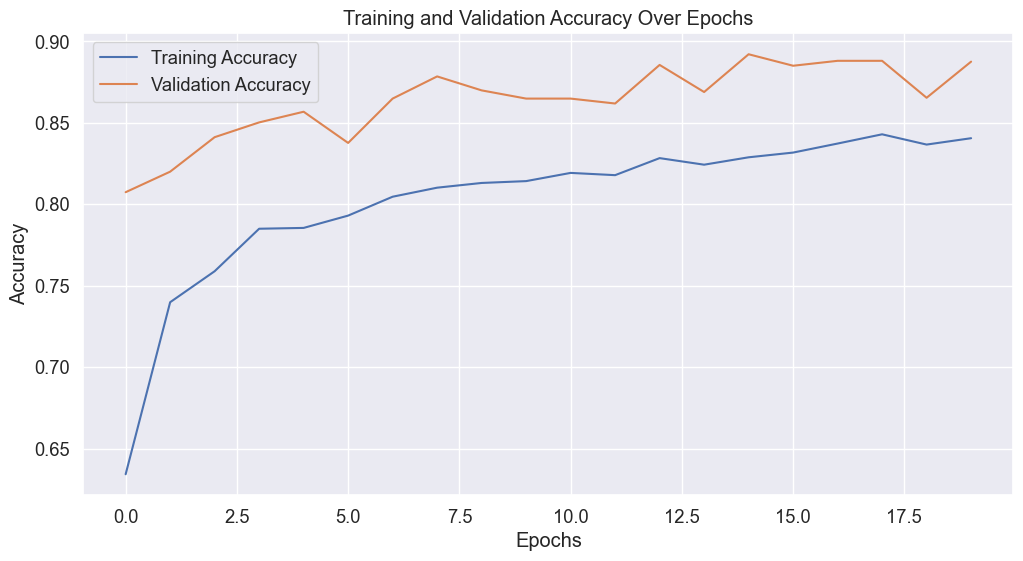

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(history_vgg19.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [30]:
# Get true labels
y_true = test_generator.labels

# Get predicted labels
predictions = vgg19_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100
f1 = f1_score(y_true, y_pred, average='weighted') * 100


print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1:.2f}%")

78/78 [==============================] - 45s 585ms/step
Accuracy: 90.00%
Precision: 90.04%
Recall: 90.00%
F1-Score: 90.01%


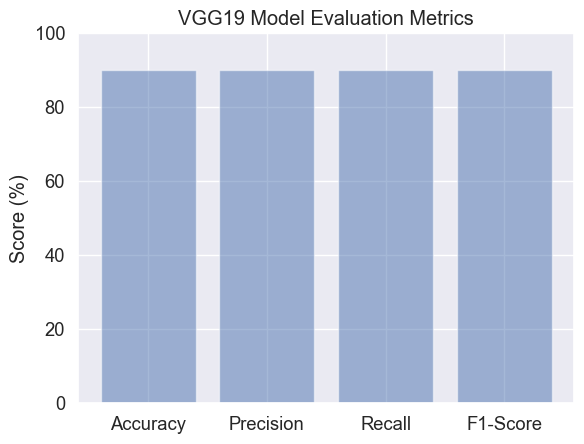

In [31]:
# Metrics stored in a list
metrics = [accuracy, precision, recall, f1]

# List of metric names
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']


y_pos = np.arange(len(labels))
plt.bar(y_pos, metrics, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Score (%)')
plt.title('VGG19 Model Evaluation Metrics')
plt.ylim([0, 100])

plt.show()

78/78 [==============================] - 31s 396ms/step


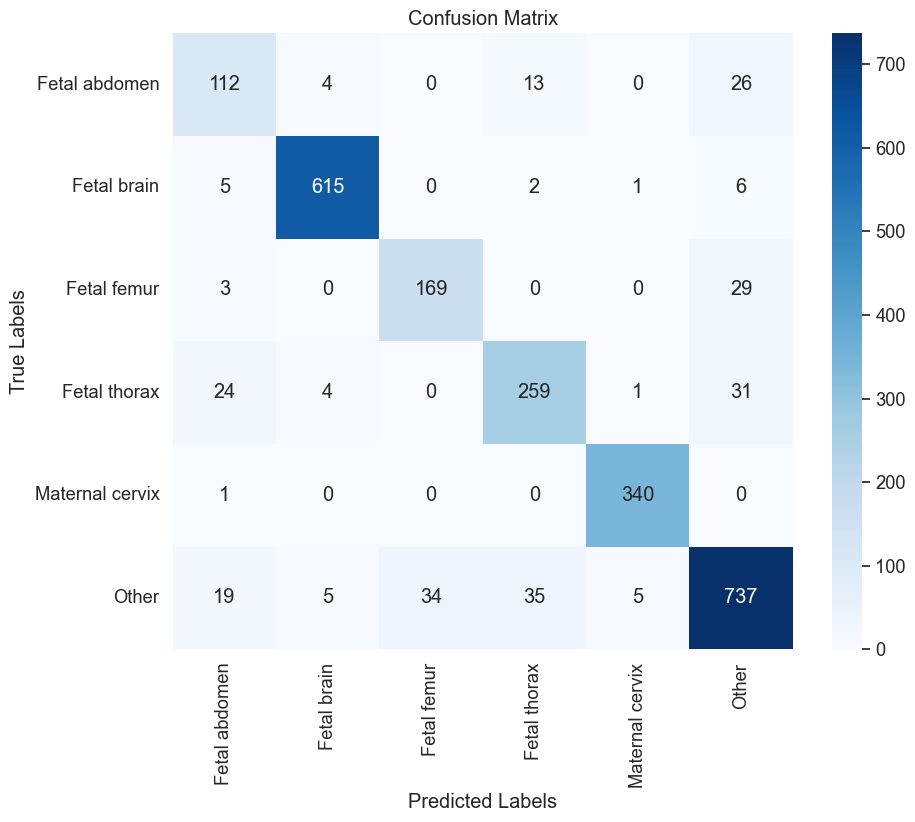

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# True labels from the generator
true_labels = test_generator.labels

# Predictions
predictions = vgg19_model.predict(test_generator, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()